<small>
---
© 2025 Monobina Bhowmick-Saha  
Original Repo: https://github.com/monobinab-source/ai-ml/tree/main/emeritus-ai-ml/music_transcribe  
Licensed under the MIT License. See the LICENSE file for details.  
---
</small>


# Research Question:
Can we accurately predict MIDI notes from audio recordings using machine learning models trained on spectrogram representations and other extracted audio features?

## Expected Data Source(s):
I will use audio and corresponding MIDI files from the MAESTRO dataset, which contains high-quality classical piano performances with aligned MIDI transcriptions. These recordings will serve as training data for both classical machine learning and deep learning models.

## Techniques Expected to Use:
### Feature Extraction:
Compute Mel spectrograms and their logarithmic representations.
Extract additional relevant audio features such as MFCCs, spectral centroid, zero-crossing rate, and chroma features to be used in a structured dataset.

### Traditional Machine Learning Models:
Use classical ML techniques like Random Forest and Support Vector Machines (SVM) by structuring the extracted features into a DataFrame format, where audio features serve as input and corresponding MIDI notes as target labels for classification.

### Deep Learning Models:
Convolutional Neural Networks (CNNs): Train models using spectrogram representations to explore different CNN architectures and optimize layers, neurons, and activation functions for audio classification.
Transfer Learning: Utilize pre-trained models such as ResNet to compare how well transfer learning improves note classification accuracy.
Recurrent Neural Networks (LSTM): Since music involves a temporal sequence component, I will experiment with LSTMs to evaluate their effectiveness in capturing time-dependent variations in note velocity and sequences.
Model Evaluation:
Compare the classification performance of traditional ML models vs. deep learning models using metrics like accuracy, precision, recall, and F1-score.
Analyze how well CNN-based models outperform traditional ML methods and whether LSTM-based models improve classification by handling sequential dependencies in musical notes.


## Audio Data Processing
### End-to-end Learning with Raw Audio
Raw waveform is passed into the network directly.

Requires 1D convolutions or temporal models that can handle thousands of input samples per second.

### Why we usually don't use raw audio in music transcription:
1. Raw audio is high-dimensional: e.g., 1 second at 22,050 Hz = 22,050 values.

2. Neural nets must learn both:

    *  Feature extraction (e.g., detecting pitch, rhythm)
    *  Classification/transcription task

This demands huge datasets and longer training times.

That's why most music/audio ML pipelines use:

    *  Log-mel spectrograms
    *  MFCCs (Mel Frequency Cepstral Coefficients)
    *  Chromagrams as inputs to CNN/RNN/Transformer models

Given the high dimensionality and the need of large datasets and processing power, I want to approach the problem by feature extraction steps,  

#### Get the required libraries
**librosa Library**

For audio digitization librosa library is useful. Librosa turns raw audio files into the rich, ready-to-use numerical features (spectrograms, beats, pitches, etc.) that is needed for downstream tasks like classification, transcription, or generative modeling.
Librosa loads audio files into NumPy arrays (librosa.load). It can resample, trim silence, and write files back to disk.

**TensorFlow Library**
is an open-source platform for building and deploying machine learning models.

**pretty-midi Library**
pretty_midi is a Python library that makes it easy to work with MIDI data programmatically.

In [ ]:
# one time install librosa in Codio env
!pip install librosa
!pip install pretty_midi
!pip install tensorflow
!pip install google-cloud-storage

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 40.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 4.8 MB/s eta 0:00:00
  Created wheel for pretty_midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592286 sha256=434cf8edc3938a14fe16d89966b965da7b6452a72a388e609634777c4f1ffd0c
  Stored in directory: /root/.cache/pip/wheels/cd/a5/30/7b8b7f58709f5150f67f98fde4b891ebf0be9ef07a8af49f25
Successfully built pretty_midi


In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import zipfile
import pretty_midi
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_score
from tensorflow.keras import layers, models
#from magenta import magenta_convert
from google.cloud import storage

## Data Source
maestrov2 dataset from Kaggle
The entire maestrov2 dataset is downloaded from Kaggle and saved in my local inside Documents folder and then uploaded to GCS.

GCS set up details:

1. From GCP console, a bucket is created named "audio_and_midi_files"
2. A folder is created named "2018"
3. To avoid errors the permissions is set to public for the time being.
4. All other options are kept as default
The mp3 files and corresponding midi files exist in the same folder called sample_data and the file names are consistent:

Loop through .mp3 files
Find the corresponding .mid file in the same folder
Since there are many files we can pick and choose about 50 files to prevent out of memory issue.

In [ ]:
# ensuring gcs path is visible from here
!gsutil ls gs://audio_and_midi_files/2018/

gs://audio_and_midi_files/2018/MIDI-Unprocessed_Chamber1_MID--AUDIO_07_R3_2018_wav--2.midi
gs://audio_and_midi_files/2018/MIDI-Unprocessed_Chamber1_MID--AUDIO_07_R3_2018_wav--2.mp3
gs://audio_and_midi_files/2018/MIDI-Unprocessed_Chamber2_MID--AUDIO_09_R3_2018_wav--1.midi
gs://audio_and_midi_files/2018/MIDI-Unprocessed_Chamber2_MID--AUDIO_09_R3_2018_wav--1.mp3
gs://audio_and_midi_files/2018/MIDI-Unprocessed_Chamber2_MID--AUDIO_09_R3_2018_wav--3.midi
gs://audio_and_midi_files/2018/MIDI-Unprocessed_Chamber2_MID--AUDIO_09_R3_2018_wav--3.mp3
gs://audio_and_midi_files/2018/MIDI-Unprocessed_Chamber3_MID--AUDIO_10_R3_2018_wav--1.midi
gs://audio_and_midi_files/2018/MIDI-Unprocessed_Chamber3_MID--AUDIO_10_R3_2018_wav--1.mp3
gs://audio_and_midi_files/2018/MIDI-Unprocessed_Chamber3_MID--AUDIO_10_R3_2018_wav--2.midi
gs://audio_and_midi_files/2018/MIDI-Unprocessed_Chamber3_MID--AUDIO_10_R3_2018_wav--2.mp3
gs://audio_and_midi_files/2018/MIDI-Unprocessed_Chamber3_MID--AUDIO_10_R3_2018_wav--3.midi
gs:/

### Load Data in the environment

In [ ]:
from google.cloud import storage
import os

project_id = 'monobina-saha'
bucket_name = 'audio_and_midi_files'
data_prefix = '2018/'

# using python storage client connecting to GCS
client = storage.Client(project=project_id)
bucket = client.bucket(bucket_name)

# downloaded files from GCS bucket and folder to the local VM where this colab
#notebook is running for ML use cases faster access of files
local_data_dir = '/tmp/audio_and_midi'
os.makedirs(local_data_dir, exist_ok=True)

blobs = list(bucket.list_blobs(prefix=data_prefix))

print(f"Found {len(blobs)} files")

# not getting all files from GCS. Getting only 100 files for efficiency and cost
file_count = 0
max_files = 100

for blob in blobs:
    if blob.name.endswith('.mp3') or blob.name.endswith('.midi') or blob.name.endswith('.mid'):
        filename = os.path.basename(blob.name)

        if filename == "":
            continue

        local_path = os.path.join(local_data_dir, filename)
        print(f"Downloading {filename}...")
        blob.download_to_filename(local_path)

        file_count += 1
        if file_count >= max_files:
            break

# checked in left panel of colab inside vertex ai => files => tmp=> audio_and_midi => 2018 => files
print("Download complete.")
print("Files downloaded:", os.listdir(local_data_dir))


Found 199 files
Download complete.
Files downloaded: ['MIDI-Unprocessed_Chamber2_MID--AUDIO_09_R3_2018_wav--1.mp3', 'MIDI-Unprocessed_Recital1-3_MID--AUDIO_03_R1_2018_wav--2.mp3', 'MIDI-Unprocessed_Chamber2_MID--AUDIO_09_R3_2018_wav--3.mp3', 'MIDI-Unprocessed_Recital17-19_MID--AUDIO_17_R1_2018_wav--3.mp3', 'MIDI-Unprocessed_Recital13-15_MID--AUDIO_15_R1_2018_wav--2.midi', 'MIDI-Unprocessed_Recital13-15_MID--AUDIO_14_R1_2018_wav--3.midi', 'MIDI-Unprocessed_Chamber6_MID--AUDIO_20_R3_2018_wav--1.mp3', 'MIDI-Unprocessed_Recital1-3_MID--AUDIO_03_R1_2018_wav--2.midi', 'MIDI-Unprocessed_Recital13-15_MID--AUDIO_13_R1_2018_wav--2.midi', 'MIDI-Unprocessed_Chamber5_MID--AUDIO_18_R3_2018_wav--1.mp3', 'MIDI-Unprocessed_Chamber6_MID--AUDIO_20_R3_2018_wav--3.midi', 'MIDI-Unprocessed_Recital13-15_MID--AUDIO_14_R1_2018_wav--2.midi', 'MIDI-Unprocessed_Recital1-3_MID--AUDIO_01_R1_2018_wav--1.mp3', 'MIDI-Unprocessed_Recital1-3_MID--AUDIO_03_R1_2018_wav--4.midi', 'MIDI-Unprocessed_Recital1-3_MID--AUDIO_02_

## Exploratory Data Analysis
In order to explore audio data we need to digitize it first.

### Digitize Audio Signal & Load in Variables
Digital audio is a discrete representation of continuous sound waves. Sampling rate refers to the number of times per second that a sound wave is measured (or sampled) to create the digital representation. It's measured in Hertz (Hz). A higher sampling rate generally captures more detail of the audio, leading to better quality. Why 22050 Hz?

Common Standard: 22050 Hz is a widely used standard sampling rate in audio processing. It's considered sufficient for capturing the frequencies audible to most humans.

Nyquist-Shannon Sampling Theorem states that to accurately reconstruct a signal, the sampling rate must be at least twice the highest frequency present in the signal. Since the human hearing range is roughly up to 20,000 Hz, 22050 Hz provides enough samples to capture those frequencies.

Computational Efficiency: Using a lower sampling rate (like 22050 Hz compared to 44100 Hz) can reduce the amount of data and processing power needed, making tasks like feature extraction and model training more efficient.

**Find Mel Spectograms of songs and visualize a few:**
Mel spectogram is a visual fingerprint of sound. On x-axis there is time and frequencies are on the y-axis. Colors show how strong the sound is. "Mel" stands for mel scale, which mimics how our ears perceive pitch.

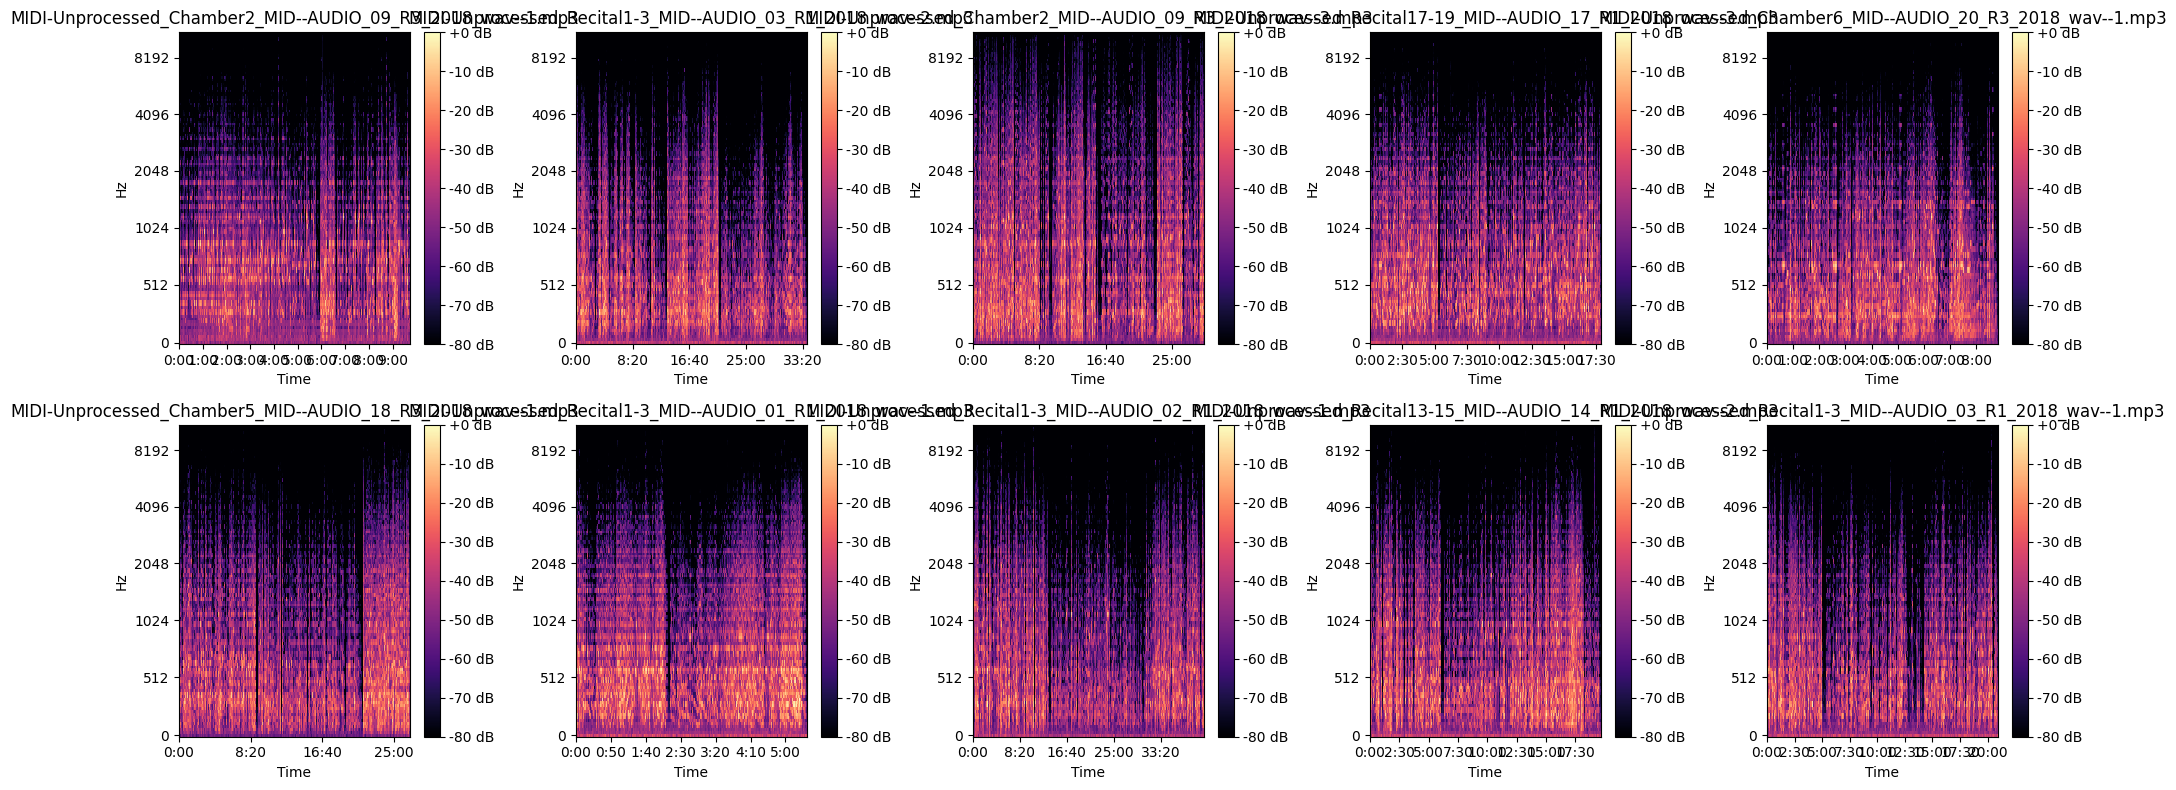

In [ ]:
import glob
import os
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

# Get a list of all MP3 files in the local folder '/tmp/audio_and_midi'
mp3_files = glob.glob("/tmp/audio_and_midi/*.mp3")

# For exploration, we choose the first 10 files (adjust as needed)
num_samples = 10
sample_files = mp3_files[:num_samples]

# Prepare list to store spectrogram shapes for later review
spectrogram_shapes = []

# Set up subplots in a grid; adjust rows/cols based on number of samples
ncols = 5
nrows = (num_samples + ncols - 1) // ncols  # ceiling division for number of rows
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 8))
axes = axes.flatten()  # ease indexing

# Loop through each selected MP3 file
for i, file_path in enumerate(sample_files):
    # Load audio file from /tmp/audio_and_midi
    y, sr = librosa.load(file_path, sr=22050)

    # Compute Mel spectrogram
    spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)

    # Convert to log scale (dB)
    log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)

    # Save the shape for reference
    spectrogram_shapes.append(log_spectrogram.shape)

    # Plot in the subplot; you can change x_axis and y_axis options as desired
    img = librosa.display.specshow(log_spectrogram, sr=sr, x_axis='time', y_axis='mel', ax=axes[i])
    axes[i].set_title(os.path.basename(file_path))
    fig.colorbar(img, ax=axes[i], format='%+2.0f dB')

# Hide any empty subplots (if fewer than nrows*ncols files)
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

# Print out the shapes of the log-spectrograms for each file
print("Shapes of the log-mel spectrograms:")
for shape in spectrogram_shapes:
    print(shape)


### EDA Continued
**Mel Spectogram Visualization of one song**
Get mel spectogram from one song and plot it to develop understanding about data.
0 dB means loudest.

Negative means softer and more negative means quieter.

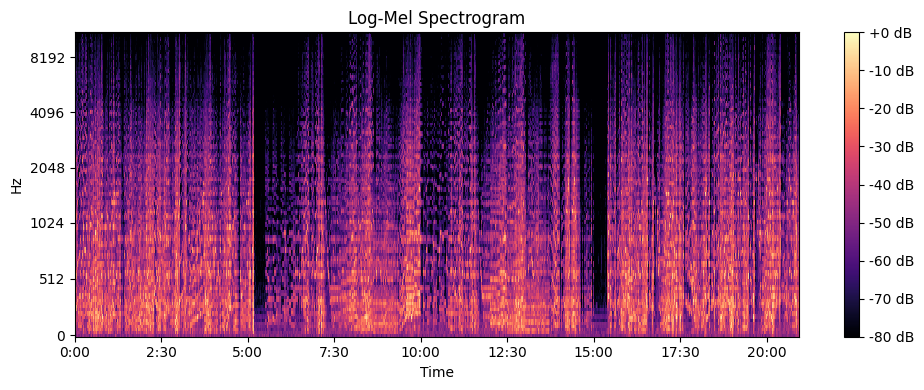

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import os

# Specify the path to a single audio file in your local directory
audio_path = "/tmp/audio_and_midi/MIDI-Unprocessed_Chamber1_MID--AUDIO_07_R3_2018_wav--2.mp3"

# Load the audio; librosa.load will resample it to 22050 Hz by default
y, sr = librosa.load(audio_path, sr=22050)

# Compute the Mel spectrogram with 128 Mel bands
mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)

# Convert the power spectrogram to a logarithmic scale (in decibels) to make it standardised
log_mel = librosa.power_to_db(mel_spec, ref=np.max)

# Plot the log-mel spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(log_mel, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title("Log-Mel Spectrogram")
plt.tight_layout()
plt.show()


### Print Numerical representation / embedding of a sample song
Here's how we can get a glimpse of the numerical embeddings (log-mel spectrogram) that are created as features in the pipeline. In our case, these “embeddings” are essentially the log-scaled Mel spectrogram values—a 2D NumPy array where each row represents a Mel frequency band and each column represents a time frame.

In [ ]:
import librosa
import librosa.display
import numpy as np

# Path to one audio file in your local environment (adjust the path as needed)
audio_path = "/tmp/audio_and_midi/MIDI-Unprocessed_Chamber1_MID--AUDIO_07_R3_2018_wav--2.mp3"

# Load the audio (resampling to 22050 Hz)
y, sr = librosa.load(audio_path, sr=22050) # it creates an array of audio samples

# It chops the waveform into short overlapping time windows (frames) and for each frame it finds how energy exists in 128 frequency bands. Compute the Mel spectrogram with 128 Mel bins/bands. “128” means there are 128 different frequency channels being captured.
mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128) # outputs 128 rows × T columns (time frames).

# Convert energy to dB (decibels) using log scale
log_mel = librosa.power_to_db(mel_spec, ref=np.max)

# Print the shape of the embedding (e.g., (128, time_frames)). For example, if I have an audio file of length
#T seconds sampled at 22050 Hz, I have about 22050*T samples. If you use a hop length of 512, then the approximate number of frames is:(22050*T)/512
# Output is 128 frequncy bands (rows) and cols represent length of song and values represent dB
print("Shape of the log-mel spectrogram (embedding):", log_mel.shape)

# Print a small sample (first 5 rows and first 10 columns)
print("Sample numerical embedding values (first 5 Mel bands, first 10 time frames):")
print(log_mel[:5, :10])


Shape of the log-mel spectrogram (embedding): (128, 54096)
Sample numerical embedding values (first 5 Mel bands, first 10 time frames):
[[-56.709393 -53.176792 -59.328182 -51.143177 -47.138245 -51.23387
  -52.139297 -46.46357  -48.665955 -48.09493 ]
 [-53.650818 -50.696117 -52.008636 -51.541836 -47.065186 -51.460014
  -51.099594 -45.08458  -47.05046  -52.433167]
 [-54.415005 -53.63242  -53.1332   -55.494698 -56.127747 -53.730858
  -53.5968   -56.81347  -55.758472 -59.749763]
 [-55.228127 -53.720047 -51.840637 -50.51509  -51.10706  -50.87343
  -51.32392  -55.153625 -52.20302  -51.586777]
 [-58.494766 -53.854427 -50.157997 -49.20588  -49.173912 -48.715027
  -50.744934 -52.256752 -50.36964  -50.405495]]


The above matrix can be read in this way:
1. For each time window (512/22050 ~ 23 ms) there are 128 values of frequency bands. So, even though the original audio is sampled at 22050 samples/sec, the log-mel spectrogram is computed every 512 samples, not every 1.
2. Each value is a decibel, a  logarithmic measure of loudness.
3. The first 5 rows are starting with lowest frequencies of 128 total frequencies.
4. 10 columns represent the first 10 time frames (beginning of the song).

In the first ~0.25 seconds of the song, there are moderate energy levels in the lower frequency bands — not total silence, but also not very loud. This could be the intro of a piano piece where lower notes are gently being played.

### Analyse corresponding MIDI file

In [ ]:
import pretty_midi

# Replace .mp3 with .midi to get the corresponding MIDI file path
midi_path = "/tmp/audio_and_midi/MIDI-Unprocessed_Chamber1_MID--AUDIO_07_R3_2018_wav--2.midi"

# Load the MIDI file
midi_data = pretty_midi.PrettyMIDI(midi_path)

# List all instruments
for i, instrument in enumerate(midi_data.instruments):
    print(f"Instrument {i}: {'Piano' if instrument.is_drum == False else 'Drum'}, Program: {instrument.program}, Notes: {len(instrument.notes)}")

# Inspect first few notes
for note in midi_data.instruments[0].notes[:10]:
    print(f"Note: {note.pitch} ({pretty_midi.note_number_to_name(note.pitch)}), "
          f"Start: {note.start:.2f}s, End: {note.end:.2f}s, Velocity: {note.velocity}")


Instrument 0: Piano, Program: 0, Notes: 12190
Note: 74 (D5), Start: 1.03s, End: 1.23s, Velocity: 86
Note: 38 (D2), Start: 1.04s, End: 1.25s, Velocity: 77
Note: 34 (A#1), Start: 1.27s, End: 1.31s, Velocity: 64
Note: 73 (C#5), Start: 1.24s, End: 1.32s, Velocity: 69
Note: 37 (C#2), Start: 1.24s, End: 1.32s, Velocity: 64
Note: 71 (B4), Start: 1.27s, End: 1.34s, Velocity: 71
Note: 69 (A4), Start: 1.35s, End: 1.39s, Velocity: 76
Note: 35 (B1), Start: 1.32s, End: 1.40s, Velocity: 64
Note: 33 (A1), Start: 1.35s, End: 1.41s, Velocity: 77
Note: 79 (G5), Start: 1.53s, End: 1.57s, Velocity: 76


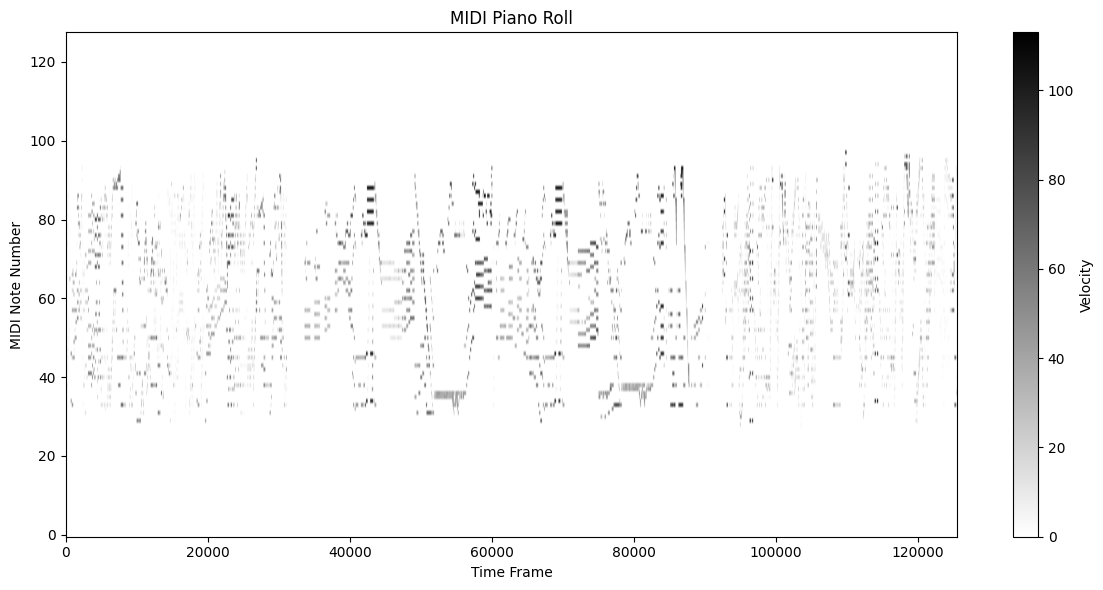

In [ ]:
import matplotlib.pyplot as plt
import pretty_midi

midi_data = pretty_midi.PrettyMIDI(midi_path)
piano_roll = midi_data.get_piano_roll(fs=100)  # 100 time frames per second

plt.figure(figsize=(12, 6))
plt.imshow(piano_roll, aspect='auto', origin='lower', cmap='gray_r')
plt.title("MIDI Piano Roll")
plt.xlabel("Time Frame")
plt.ylabel("MIDI Note Number")
plt.colorbar(label="Velocity")
plt.tight_layout()
plt.show()


#### Velocity represents intensity or loudness.

## Prepare the downlaoded mp3 and midi files for training

This code processes up to 50 pairs of MP3 and MIDI files, extracting features from the audio and corresponding labels from the MIDI, preparing them for training a model like a CNN or RNN for music transcription.

In [ ]:
import os
import librosa
import pretty_midi
import numpy as np

# Directory with downloaded MP3 and MIDI files
data_dir = "/tmp/audio_and_midi"
sr = 16000  # Audio sample rate

X = []
Y = []
pair_count = 0
max_pairs = 50  # Limit to avoid OOM errors

# Loop through downloaded files
for filename in os.listdir(data_dir):
    if filename.endswith(".mp3"):
        base_name = os.path.splitext(filename)[0]
        audio_path = os.path.join(data_dir, base_name + ".mp3")
        midi_path = os.path.join(data_dir, base_name + ".midi")

        if os.path.exists(midi_path):
            try:
                # Load audio
                y, _ = librosa.load(audio_path, sr=sr)
                mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
                log_mel = librosa.power_to_db(mel_spec, ref=np.max)

                # Load MIDI
                midi_data = pretty_midi.PrettyMIDI(midi_path)
                piano_roll = midi_data.get_piano_roll(fs=100)[21:109, :]  # 88 keys only

                # Ensure enough frames
                if log_mel.shape[1] >= 100 and piano_roll.shape[1] >= 100:
                    X.append(log_mel[:, :100])
                    Y.append(piano_roll[:, :100])
                    pair_count += 1

            except Exception as e:
                print(f"Error processing {base_name}: {e}")

        if pair_count >= max_pairs:
            break

print("Processed pairs:", pair_count)


Processed pairs: 50


### Extract Basic Features from Spectogram of Audio
We can extract Mel Spectrogram and MFCCs (Mel-Frequency Cepstral Coefficients), which are widely used for audio classification. Why use these features?

Mel Spectrogram represents how sound energy is distributed across frequencies over time.

MFCCs: This is useful for distinguishing different sounds (used in speech recognition and music classification). They capture the spectral envelope of the sound and are robust to variations in loudness and recording conditions.

Spectral Centroid: This feature represents the "center of mass" of the spectrum, indicating the average frequency weighted by amplitude.

Spectral Bandwidth: This measures the width of the spectrum, indicating the range of frequencies present in the sound.

Zero-Crossing Rate: This feature counts the number of times the audio waveform crosses zero, providing information about the frequency content and noisiness of the sound.

Chroma Features: These represent the distribution of energy across the 12 chromatic pitches (C, C#, D, etc.), providing information about the harmonic content of the music.

Note Onsets and Offsets: You can extract the time points where notes start (onsets) and end (offsets) to analyze rhythmic patterns.

Extract Features from Piano Roll (Y)
Note Density: This feature calculates the number of notes played per time frame, indicating the musical texture.

Pitch Class Distribution: This represents the distribution of notes across the 12 pitch classes (C, C#, D, etc.), providing information about the key or scale of the music.

In [ ]:
# Feature extraction after splitting
audio_features = []
piano_roll_features = []

print("Length of X: ", len(X))

for i in range(len(X)):
    # Features from digitized audio (X)
    mfccs = librosa.feature.mfcc(y=X[i], sr=sr, n_mfcc=13)  # Assuming you have the sampling rate (sr)
    spectral_centroid = librosa.feature.spectral_centroid(y=X[i], sr=sr)
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=X[i], sr=sr)
    zero_crossing_rate = librosa.feature.zero_crossing_rate(y=X[i])
    chroma_features = librosa.feature.chroma_stft(y=X[i], sr=sr)
    onsets = librosa.onset.onset_detect(y=X[i], sr=sr) # Assuming you have audio corresponding to the piano roll


    audio_features.append(np.concatenate([mfccs.flatten(), spectral_centroid.flatten(), spectral_bandwidth.flatten(), zero_crossing_rate.flatten(), chroma_features.flatten()]))  # Combine features

    # Features from piano roll (Y)
    note_density = np.sum(Y[i], axis=0)
    pitch_class_distribution = np.sum(Y[i], axis=1) % 12

    # ... extract other piano roll features ...

    piano_roll_features.append(np.concatenate([note_density, pitch_class_distribution])) # Combine features


# Convert to NumPy arrays
audio_features = np.array(audio_features)
piano_roll_features = np.array(piano_roll_features)

Length of X:  50


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=100
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


Print Features for Supervised Learning

In [ ]:
# check length and type of audio fetaures and piano roll features
print(len(audio_features))
print(len(piano_roll_features))
print(type(audio_features))
print(type(piano_roll_features))

# Print shapes of individual features
print("MFCCs shape:", mfccs.shape)
print("Spectral Centroid shape:", spectral_centroid.shape)
print("Spectral Bandwidth shape:", spectral_bandwidth.shape)
print("Zero-Crossing Rate shape:", zero_crossing_rate.shape)
print("Chroma Features shape:", chroma_features.shape)
print("Audio Features Shape:", audio_features.shape)
print("Piano Roll Features Shape:", piano_roll_features.shape)

# print("MFCCs:", mfccs)
# Print first sample
print("First X sample:\n", audio_features[0])
print("First Y sample:\n", piano_roll_features[0])

50
50
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
MFCCs shape: (128, 13, 1)
Spectral Centroid shape: (128, 1, 1)
Spectral Bandwidth shape: (128, 1, 1)
Zero-Crossing Rate shape: (128, 1, 1)
Chroma Features shape: (128, 12, 1)
Audio Features Shape: (50, 3584)
Piano Roll Features Shape: (50, 188)
First X sample:
 [350.03018188  82.43812561  25.38121033 ...   0.97281122   0.86911464
   0.89133304]
First Y sample:
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0. 60. 60. 60. 60. 60.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0

Mel Spectogram and MFCC Visualization

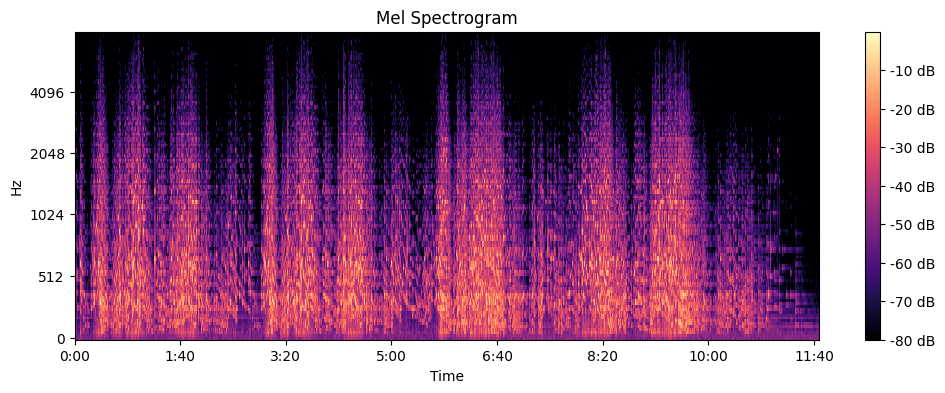

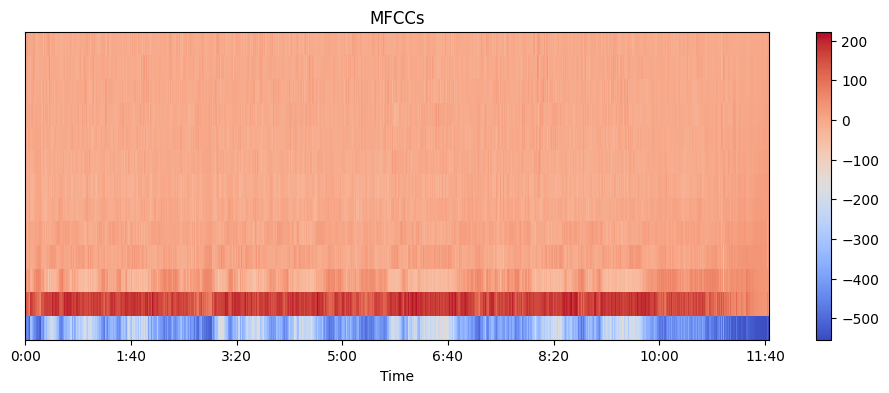

In [ ]:

# Compute Mel spectrogram
mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

# Plot Mel spectrogram
plt.figure(figsize=(12, 4))
librosa.display.specshow(log_mel_spectrogram, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title("Mel Spectrogram")
plt.show()

# Extract MFCCs
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

# Plot MFCCs
plt.figure(figsize=(12, 4))
librosa.display.specshow(mfccs, sr=sr, x_axis='time')
plt.colorbar()
plt.title("MFCCs")
plt.show()

The Mel spectrogram plot
It provides a visual representation of the frequency content of your MP3 file over time. Here's what it tells us:

X-axis (Time) Represents time in seconds. Shows how the audio's frequency components change over time.
Y-axis (Frequency - Mel Scale) Represents frequency, but instead of linear Hz, it's in the Mel scale, which aligns with human perception. Lower values = lower-pitched sounds (bass, deep voice). Higher values = higher-pitched sounds (treble, sharp sounds).
Color Intensity (dB - Decibels) Shows the amplitude (loudness) of each frequency component. Brighter (yellow/white) = louder sounds at that frequency. Darker (blue/purple) = softer sounds.

### Waveform plot
A simple plot to understand the audio data and it's amplitude dynamics (loud vs soft) and the overall signal shape by plotting one song as sample.

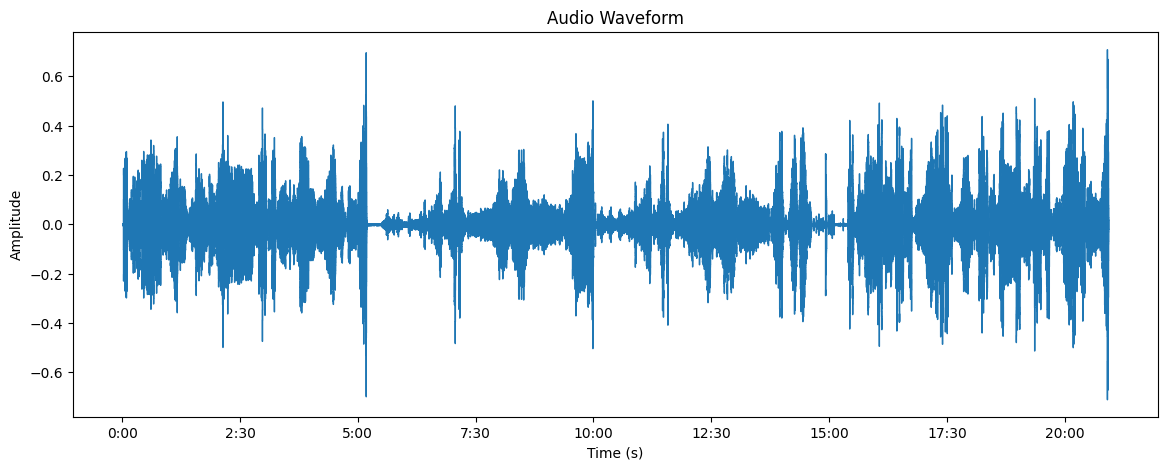

In [ ]:
import matplotlib.pyplot as plt
import librosa
import librosa.display

audio_path = "/tmp/audio_and_midi/MIDI-Unprocessed_Chamber1_MID--AUDIO_07_R3_2018_wav--2.mp3"

y, sr = librosa.load(audio_path, sr=22050)

plt.figure(figsize=(14, 5))
librosa.display.waveshow(y, sr=sr)
plt.title("Audio Waveform")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()


The above waveform depicts the following:
1. Overall Duration: Overall duration of the song is 20 mins.
2. Amplitude Changes: Amplitude is scaled/normalized by librosa.load() function and here loudest peak is 0.6 and softest valley is -0.6.
3. Temporal Structure: The beginning and ending parts have more number of higher spikes in signal suggesting more energy while the middle part is milder.
4. Balance and Symmetry: POsitive and negative swings are symmetrical.
5. There are a couple of momemts where waveform have 0 in y-axis suggesting near-silent sections.

### MFCCs (Mel-Frequency Cepstral Coefficients)
MFCCs capture timbral aspects of audio and are widely used in speech and music analysis. Plotting these can reveal differences in the “texture” of the sound, often used for classification tasks.

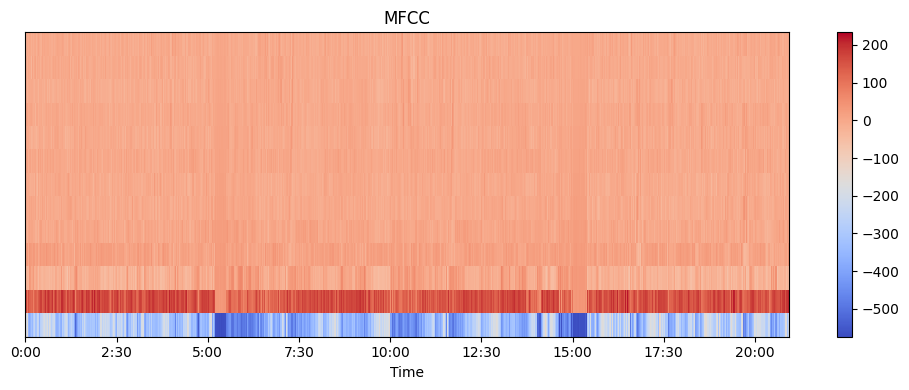

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

y, sr = librosa.load(audio_path, sr=22050)
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.title("MFCC")
plt.tight_layout()
plt.show()


Color Bar (MFCC Coefficient Value Range) : The color range from -600 to 200 represents the numeric values of the MFCC coefficients.

Prolonged Red Band near the Top: I have a large area of red/pink from about 0 to 20 minutes on the top half of the MFCC axis. This often indicates that certain coefficients (e.g., the lower-numbered MFCCs) are strong or positive. It might reflect consistent spectral or harmonic content throughout the piece.

Bluish Band near the Bottom: The bottom section of the plot has intense negative values (blue). These could correspond to higher-numbered MFCC coefficients that are capturing some specific, more subtle aspects of the timbre or that reflect quietness or an imbalance in the frequency content.

Time Variation: There are occasional stripes or changes, especially around certain time marks (e.g., 5 minutes, 7:30, etc.). These could indicate transitions in the music—like sections with a different timbral quality.



### Chromagram
A chromagram visualizes the intensity of each of the 12 pitch classes (C, C#/Db, D, etc.) as a function of time. It’s helpful to analyze harmonic content and chord progressions.

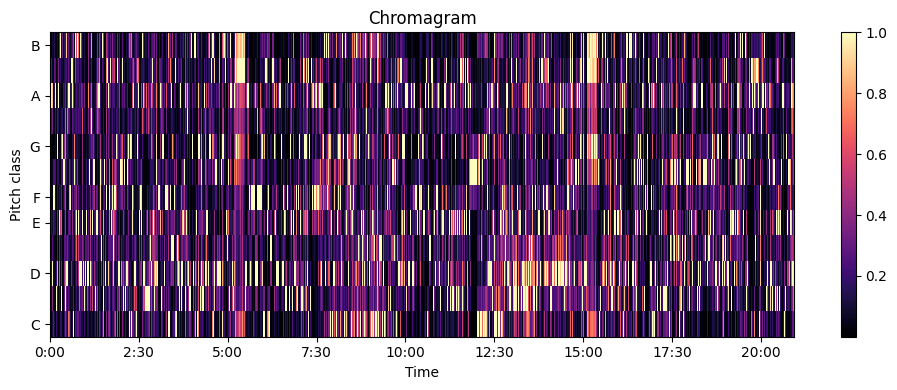

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

y, sr = librosa.load(audio_path, sr=22050)
chromagram = librosa.feature.chroma_stft(y=y, sr=sr)

plt.figure(figsize=(10, 4))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma')
plt.colorbar()
plt.title("Chromagram")
plt.tight_layout()
plt.show()


Above chroma plot looks "rainbow-all-over". The uniformly multicolored chromagram tells me the music is very chromatic, busy, and lacks a single tonal center.
Because every pitch class (“C” through “B”) is lighting up more or less equally and continuously, the piece is exhibiting a very dense and polyphonic texture—with no single note or key standing out clearly in the chroma.
Continuous Motion
The even, multicolored look implies there aren't long “rests” in certain pitch-classes. Virtually every moment has activity somewhere in the chroma, suggesting continuous note movement rather than clear verse/chorus or repeated chord patterns.

### Onset and Tempo
Identify beats and tempo: Onset strength indicates where there are abrupt changes in energy, which often correspond to musical note onsets (or beats). It can also estimate the tempo (BPM) of the piece.

<ipython-input-15-4fbb982ad260>:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(f"Estimated Tempo: {float(tempo):.2f} BPM")


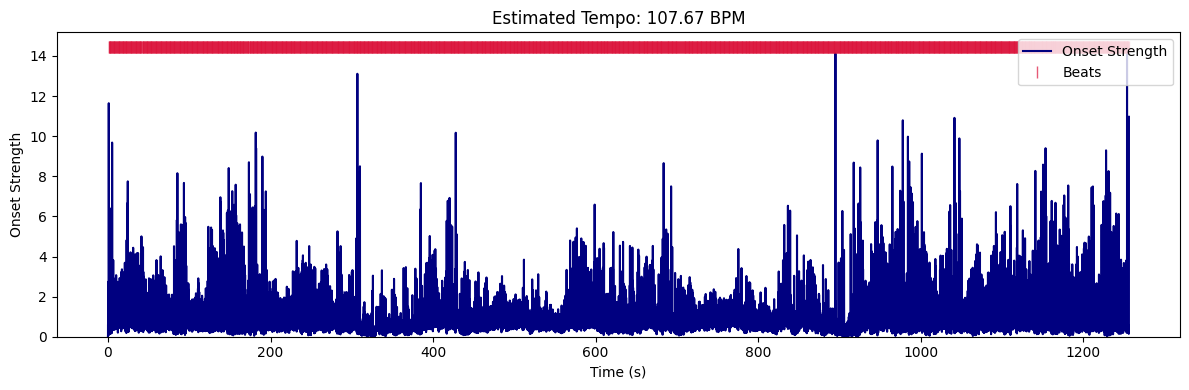

Estimated Tempo (BPM): 107.67
Beats detected: 2268 (one tick every ~0.55s at 107.67 BPM)


<ipython-input-15-4fbb982ad260>:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"Estimated Tempo (BPM): {float(tempo):.2f}")
<ipython-input-15-4fbb982ad260>:45: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  f"(one tick every ~{avg_interval:.2f}s at {float(tempo):.2f} BPM)")


In [ ]:
import librosa
import matplotlib.pyplot as plt
import numpy as np

# 1) Load + feature extraction
y, sr = librosa.load(audio_path, sr=22050)
onset_env = librosa.onset.onset_strength(y=y, sr=sr)
tempo, beat_frames = librosa.beat.beat_track(onset_envelope=onset_env, sr=sr)
beat_times = librosa.frames_to_time(beat_frames, sr=sr)
all_times = librosa.frames_to_time(range(len(onset_env)), sr=sr)
y_max = onset_env.max()

# 2) Plot onset strength
plt.figure(figsize=(12, 4))
plt.plot(all_times, onset_env, color='navy', label='Onset Strength')

# 3) Plot beats as small tick‑markers at y = y_max
plt.plot(
    beat_times,
    [y_max] * len(beat_times),   # all at the top of the curve
    linestyle='None',
    marker='|',
    markersize=8,                # much smaller
    color='crimson',
    alpha=0.7,
    label='Beats'
)

# 4) Annotate
plt.title(f"Estimated Tempo: {float(tempo):.2f} BPM")
plt.xlabel("Time (s)")
plt.ylabel("Onset Strength")
plt.ylim(0, y_max * 1.05)        # a little headroom so ticks sit above the blue line
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

print(f"Estimated Tempo (BPM): {float(tempo):.2f}")

# After I have beat_times and tempo:
intervals = np.diff(beat_times)                # differences between consecutive beats
avg_interval = intervals.mean()                 # average seconds per beat

print(f"Beats detected: {len(beat_times)} "
      f"(one tick every ~{avg_interval:.2f}s at {float(tempo):.2f} BPM)")



### Spectral Centroid & Spectral Contrast of first song
Plots the spectral centroid as a line (with real Hz on the y-axis), so I can actually see how it moves over time.

Displays spectral contrast as a heatmap with clear band indices and a proper colorbar, so I can read off which sub-band (low → high) has more or less contrast.

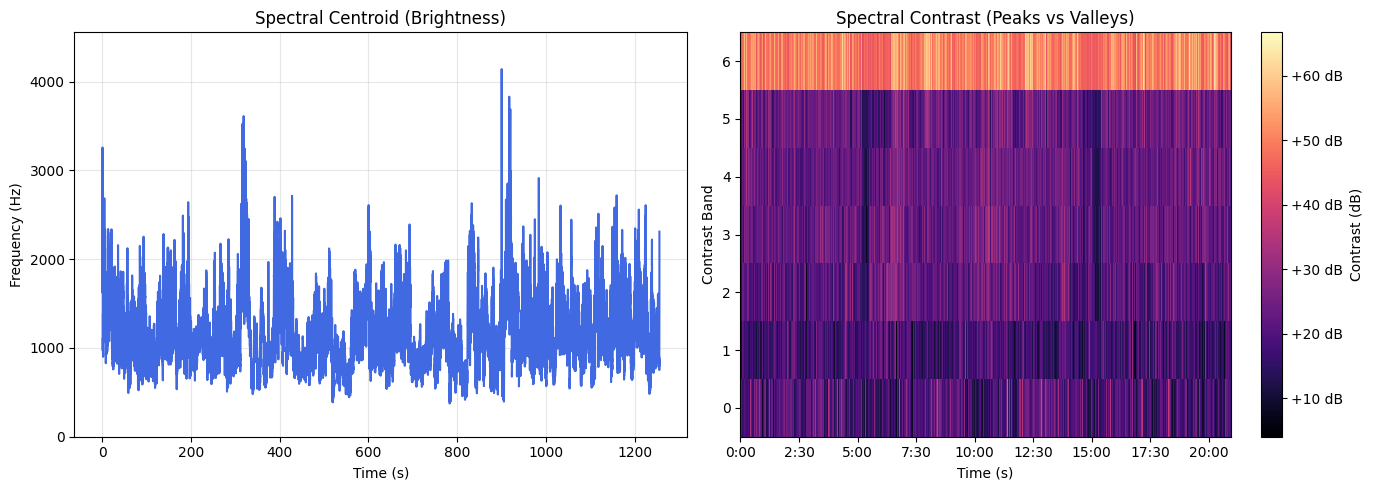

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# 1) Load audio
y, sr = librosa.load(audio_path, sr=22050)

# 2) Compute features
centroid = librosa.feature.spectral_centroid(y=y, sr=sr)[0]       # shape (T,)
contrast = librosa.feature.spectral_contrast(y=y, sr=sr)          # shape (n_bands, T)

# 3) Build time axes
t_cent = librosa.frames_to_time(np.arange(len(centroid)), sr=sr)
t_contrast = librosa.frames_to_time(np.arange(contrast.shape[1]), sr=sr)

# 4) Plot
plt.figure(figsize=(14, 5))

# --- Left: Spectral Centroid ---
plt.subplot(1, 2, 1)
plt.plot(t_cent, centroid, color='royalblue')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Spectral Centroid (Brightness)')
plt.ylim(0, np.max(centroid) * 1.1)  # little headroom
plt.grid(alpha=0.3)

# --- Right: Spectral Contrast ---
plt.subplot(1, 2, 2)
img = librosa.display.specshow(
    contrast,
    x_axis='time',
    y_axis='frames',       # each row = one contrast band
    sr=sr,
    hop_length=512,
    cmap='magma'
)
plt.xlabel('Time (s)')
plt.ylabel('Contrast Band')
plt.title('Spectral Contrast (Peaks vs Valleys)')
cbar = plt.colorbar(img, format='%+2.0f dB')
cbar.set_label('Contrast (dB)')
plt.grid(False)

plt.tight_layout()
plt.show()


#### Lets try a second song sample (it is a smaller song)
Audio waveform plot

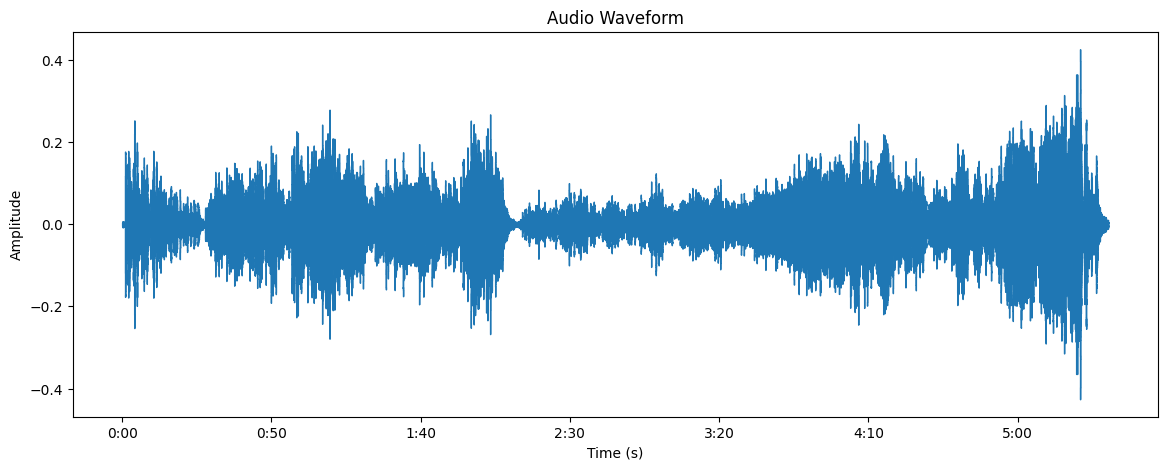

In [ ]:
import matplotlib.pyplot as plt
import librosa
import librosa.display

audio_path = "/tmp/audio_and_midi/MIDI-Unprocessed_Recital1-3_MID--AUDIO_01_R1_2018_wav--1.mp3"

y, sr = librosa.load(audio_path, sr=22050)

plt.figure(figsize=(14, 5))
librosa.display.waveshow(y, sr=sr)
plt.title("Audio Waveform")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()


### Plot MFCC of the song

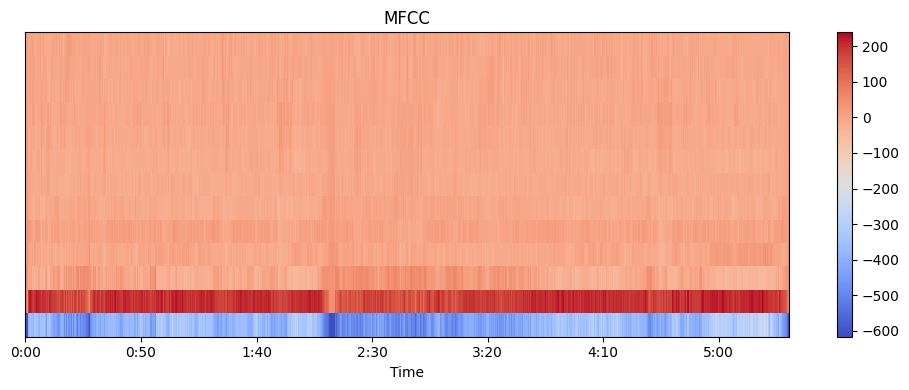

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

y, sr = librosa.load(audio_path, sr=22050)
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.title("MFCC")
plt.tight_layout()
plt.show()


### Plot Onset and Tempo of the song

<ipython-input-19-74c5ed445c47>:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(f"Estimated Tempo: {float(tempo):.2f} BPM")


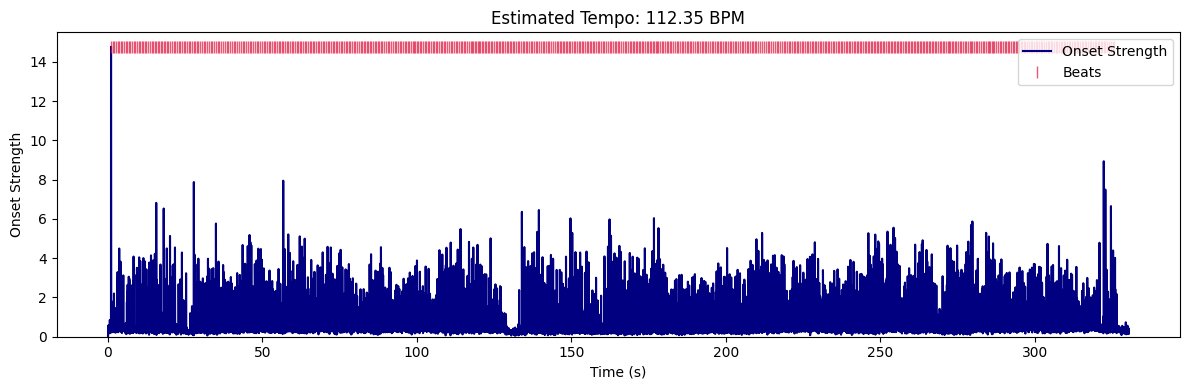

Estimated Tempo (BPM): 112.35
Beats detected: 618 (one tick every ~0.54s at 112 BPM)


<ipython-input-19-74c5ed445c47>:37: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"Estimated Tempo (BPM): {float(tempo):.2f}")


In [ ]:
import librosa
import matplotlib.pyplot as plt

# 1) Load + feature extraction
y, sr = librosa.load(audio_path, sr=22050)
onset_env = librosa.onset.onset_strength(y=y, sr=sr)
tempo, beat_frames = librosa.beat.beat_track(onset_envelope=onset_env, sr=sr)
beat_times = librosa.frames_to_time(beat_frames, sr=sr)
all_times = librosa.frames_to_time(range(len(onset_env)), sr=sr)
y_max = onset_env.max()

# 2) Plot onset strength
plt.figure(figsize=(12, 4))
plt.plot(all_times, onset_env, color='navy', label='Onset Strength')

# 3) Plot beats as small tick‑markers at y = y_max
plt.plot(
    beat_times,
    [y_max] * len(beat_times),   # all at the top of the curve
    linestyle='None',
    marker='|',
    markersize=8,                # much smaller
    color='crimson',
    alpha=0.7,
    label='Beats'
)

# 4) Annotate
plt.title(f"Estimated Tempo: {float(tempo):.2f} BPM")
plt.xlabel("Time (s)")
plt.ylabel("Onset Strength")
plt.ylim(0, y_max * 1.05)        # a little headroom so ticks sit above the blue line
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

print(f"Estimated Tempo (BPM): {float(tempo):.2f}")
print(f"Beats detected: {len(beat_times)} (one tick every ~0.54s at 112 BPM)")


#### Inference about tempo from above. plot:

A red tick at time "t" means “there's a beat here.”

The height of the blue curve at time "t" is how pronounced the energy change (onset) is at that moment—not exactly the absolute loudness, but how “percussive” or transient the signal is.

### Plot chromagram of the song

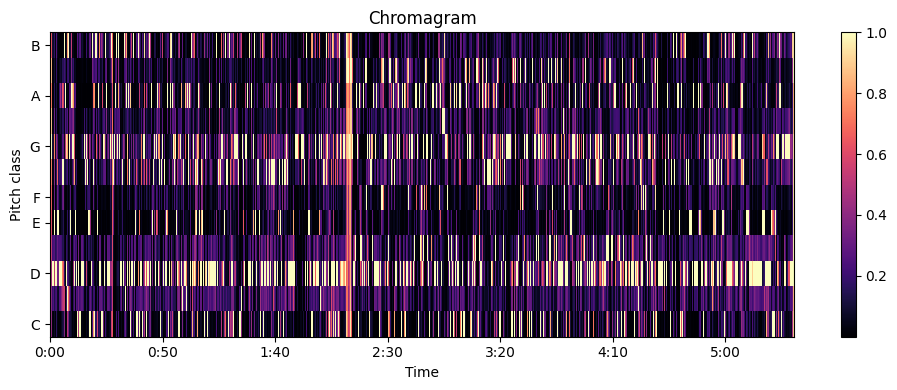

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

y, sr = librosa.load(audio_path, sr=22050)
chromagram = librosa.feature.chroma_stft(y=y, sr=sr)

plt.figure(figsize=(10, 4))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma')
plt.colorbar()
plt.title("Chromagram")
plt.tight_layout()
plt.show()

Inferences from above chromagram:
1. D-Row Dominance: D row (second from bottom) has a lot more bright, sustained patches than most other rows.
2. G-Row Activity: The G row (middle of the plot) also lights up quite often—hinting at a relationship between D and G (for example, D → G might imply a D → G chord progression, or simply that both notes recur heavily).


#### Code to Check the Average Chroma Intensity

In [ ]:
import numpy as np

# `chromagram` is your 2D array of shape (12, T)
# If you computed chromagram like this:
# chromagram = librosa.feature.chroma_stft(y=y, sr=sr)

# Compute mean energy per pitch class
avg_chroma = np.mean(chromagram, axis=1)

# Pitch‐class labels
pitch_names = ['C', 'C♯/D♭', 'D', 'D♯/E♭', 'E',
               'F', 'F♯/G♭', 'G', 'G♯/A♭', 'A',
               'A♯/B♭', 'B']

for name, val in zip(pitch_names, avg_chroma):
    print(f"{name:4s}: {val:.3f}")


C   : 0.221
C♯/D♭: 0.196
D   : 0.499
D♯/E♭: 0.212
E   : 0.136
F   : 0.120
F♯/G♭: 0.261
G   : 0.370
G♯/A♭: 0.153
A   : 0.231
A♯/B♭: 0.164
B   : 0.190


#### Average Chroma Intensity Results Inferences:
From those average chroma energies, you can infer a few things about the tonal center and harmonic content of this piano piece:

1. D is by far the strongest pitch class (avg ≈ 0.499), nearly twice any other.

2. G (0.370) and F♯ (0.261) are the next most prominent.

3. A (0.231) is also above the median.

### Spectral Centroid and Spectral Contrast Plot for the second song


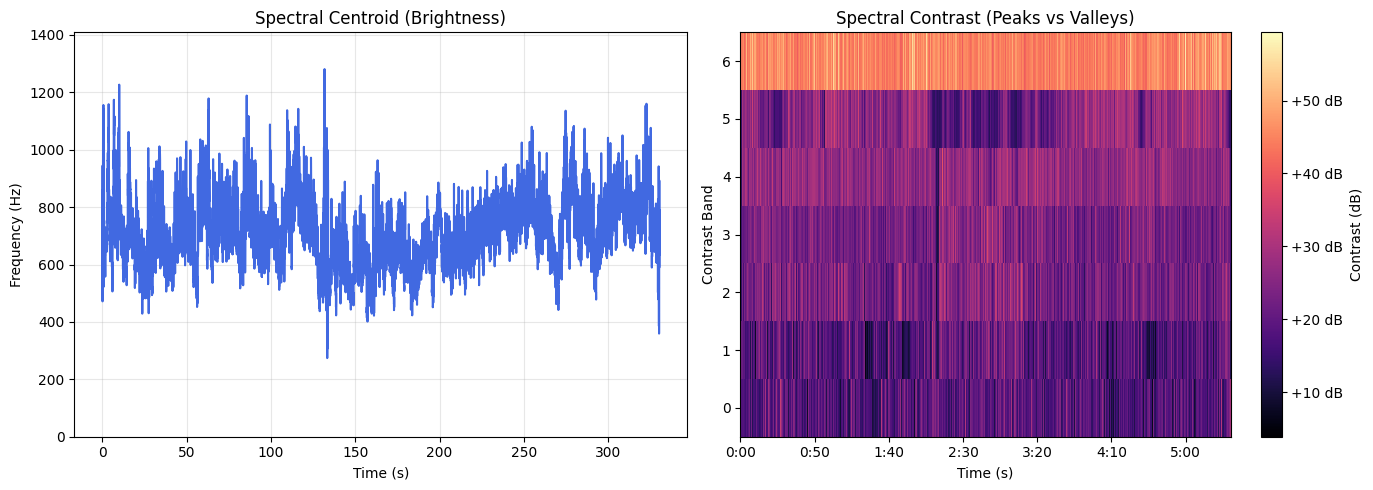

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# 1) Load audio
y, sr = librosa.load(audio_path, sr=22050)

# 2) Compute features
centroid = librosa.feature.spectral_centroid(y=y, sr=sr)[0]       # shape (T,)
contrast = librosa.feature.spectral_contrast(y=y, sr=sr)          # shape (n_bands, T)

# 3) Build time axes
t_cent = librosa.frames_to_time(np.arange(len(centroid)), sr=sr)
t_contrast = librosa.frames_to_time(np.arange(contrast.shape[1]), sr=sr)

# 4) Plot
plt.figure(figsize=(14, 5))

# --- Left: Spectral Centroid ---
plt.subplot(1, 2, 1)
plt.plot(t_cent, centroid, color='royalblue')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Spectral Centroid (Brightness)')
plt.ylim(0, np.max(centroid) * 1.1)  # little headroom
plt.grid(alpha=0.3)

# --- Right: Spectral Contrast ---
plt.subplot(1, 2, 2)
img = librosa.display.specshow(
    contrast,
    x_axis='time',
    y_axis='frames',       # each row = one contrast band
    sr=sr,
    hop_length=512,
    cmap='magma'
)
plt.xlabel('Time (s)')
plt.ylabel('Contrast Band')
plt.title('Spectral Contrast (Peaks vs Valleys)')
cbar = plt.colorbar(img, format='%+2.0f dB')
cbar.set_label('Contrast (dB)')
plt.grid(False)

plt.tight_layout()
plt.show()


#### Inferences regarding Spectral Centroid and Spectral Contrast from above plot
**Spectral Centroid Inference:**
1. If the line drifts upward, the piano is playing in a brighter register or with sharper attacks (more high-frequency content).

2. Drops in the centroid indicate darker, bass-heavy passages.

**Spectral Contrast Inference:**

1. Rows correspond to sub-bands from low (top row) to high (bottom row).

2. Brighter colors (toward +60 dB) mean that sub-band has strong peaks versus valleys—typical of percussive attacks or resonant overtones.

3. Darker colors (toward +10 dB) mean the spectrum in that band is more even, as in legato or sustained notes.

## Inference from the Data & Features Exploration
For MIDI prediction use case MFCCs don't seem to be powerful features for fine-grained pitch or note-level transcription.
MFCCs capture the envelope of the spectrum and can be used for genre prediction.

So from the above data exploration, I am planning to extract these audio features from each MP3:

1. waveform-level
2. spectral centroids
3. chroma
4. log-Mel spectogram

Pulling a simple label (most frequent MIDI pitch) from each MIDI



In [ ]:
import os
import numpy as np
import pandas as pd
import librosa
import pretty_midi

# ─── 1) Extract summary features & filename ───────────────────────────
data_dir   = '/tmp/audio_and_midi'
mp3_files  = [f for f in os.listdir(data_dir) if f.endswith('.mp3')]
rows       = []

for mp3 in mp3_files:
    base      = os.path.splitext(mp3)[0]
    aud_path  = os.path.join(data_dir, mp3)
    midi_path = os.path.join(data_dir, base + '.midi')
    if not os.path.exists(midi_path):
        continue

    # — Audio load & duration
    y, sr     = librosa.load(aud_path, sr=22050)
    duration  = librosa.get_duration(y=y, sr=sr)

    # — Rhythm features
    onset_env    = librosa.onset.onset_strength(y=y, sr=sr)
    tempo, _     = librosa.beat.beat_track(onset_envelope=onset_env, sr=sr)
    onset_frames = librosa.onset.onset_detect(y=y, sr=sr)
    onset_rate   = len(onset_frames) / duration

    # — Basic features
    rmse      = librosa.feature.rms(y=y).mean()
    zcr       = librosa.feature.zero_crossing_rate(y).mean()
    spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr).mean()
    spec_bw   = librosa.feature.spectral_bandwidth(y=y, sr=sr).mean()

    # — Spectral contrast & chroma
    contrast  = librosa.feature.spectral_contrast(y=y, sr=sr).mean(axis=1)
    chroma    = librosa.feature.chroma_stft(y=y, sr=sr).mean(axis=1)

    # — Log‑Mel summary
    mel       = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    log_mel   = librosa.power_to_db(mel, ref=np.max)
    mel_mean  = log_mel.mean(axis=1)

    # — Build feature dict
    feat = {
        'filename':    mp3,
        'tempo':       tempo,
        'onset_rate':  onset_rate,
        'rmse':        rmse,
        'zcr':         zcr,
        'spec_cent':   spec_cent,
        'spec_bw':     spec_bw,
    }
    for i, v in enumerate(contrast):
        feat[f'contrast_{i}'] = v
    for i, v in enumerate(chroma):
        feat[f'chroma_{i}']   = v
    for i, v in enumerate(mel_mean):
        feat[f'mel_mean_{i}'] = v

    # — MIDI label (most frequent pitch) just for reference
    pm    = pretty_midi.PrettyMIDI(midi_path)
    notes = [n.pitch for ins in pm.instruments for n in ins.notes]
    feat['label'] = max(set(notes), key=notes.count) if notes else None

    rows.append(feat)

# ─── 2) Build the feature matrix ───────────────────────────────────────
df = pd.DataFrame(rows).dropna(subset=['label'])
X_supervised = df.drop(['filename','label'], axis=1).values
print("X_supervised shape:", X_supervised.shape)   # (n_files, 153)

# ─── 3) Build Y_supervised as piano‑rolls ─────────────────────────────
piano_rolls = []
for mp3 in df['filename']:
    base      = os.path.splitext(mp3)[0]
    midi_path = os.path.join(data_dir, base + '.midi')
    pm        = pretty_midi.PrettyMIDI(midi_path)
    pr        = pm.get_piano_roll(fs=100)[21:109, :]    # (88, T_i)
    piano_rolls.append((pr > 0).astype(int))            # binarize

# truncate to common length
T_common   = min(pr.shape[1] for pr in piano_rolls)
piano_rolls = [pr[:, :T_common] for pr in piano_rolls]

# stack into (n_files, 88, T_common)
Y_supervised = np.stack(piano_rolls, axis=0)
print("Y_supervised shape:", Y_supervised.shape)   # (n_files, 88, T_common)


X_supervised shape: (50, 153)
Y_supervised shape: (50, 88, 14140)


#### The above code gives:

1. X_supervised → shape (n_files, 153)

2. Y_supervised → shape (n_files, 88, T_common)

This setup lets me train a sequence-to-sequence model (e.g. CNN/LSTM) that maps your 153-dim summary to an 88*T piano-roll—but usually for transcription we feed slices of the time-series (e.g. log-Mel slices) rather than global summaries.

In [ ]:
# Print the first 5 samples of X_supervised and Y_supervised
print("X_supervised (first 5 rows):\n", X_supervised[:5])
print("\nY_supervised (first 5 labels):\n", Y_supervised[:5])

X_supervised (first 5 rows):
 [[array([123.046875]) 3.4341436037251536 0.024789324030280113
  0.05732420708676699 842.6611823120561 995.875743054602
  14.878372824835152 16.957802838086035 21.240222611100243
  24.45373912675272 25.312952533361585 20.87950170402281
  45.58749230749115 0.07999527454376221 0.21468646824359894
  0.4123573303222656 0.17501796782016754 0.23263481259346008
  0.19486652314662933 0.3637816905975342 0.20713581144809723
  0.14362089335918427 0.29373615980148315 0.11836683750152588
  0.10927106440067291 -45.9979248046875 -42.17457580566406
  -41.8538703918457 -43.944374084472656 -42.32318115234375
  -45.63106155395508 -42.58613967895508 -41.03659439086914
  -43.53402328491211 -42.959869384765625 -37.28841781616211
  -36.91383743286133 -40.18511199951172 -37.55069351196289
  -38.99738693237305 -44.10958480834961 -41.01383590698242
  -44.030155181884766 -49.04688262939453 -48.200565338134766
  -44.96732711791992 -39.16838836669922 -37.78889846801758
  -44.8081626892

### Below I am slicing the mel spectogram and midi files, which is a common technique for training with audio files.

In [ ]:
import os
import numpy as np
import librosa
import pretty_midi
from glob import glob

# ────────────────
# 1) Configuration
# ────────────────
data_dir     = "/tmp/audio_and_midi"
sr           = 22050           # audio sample rate
n_mels       = 128             # mel bands
hop_length   = 512             # samples between frames
window_frames= 100             # number of frames per slice (~2.3s)
fs_roll      = sr // hop_length  # piano-roll frames per second

# ────────────────
# 2) Helper loaders
# ────────────────
def load_log_mel(path):
    y, _    = librosa.load(path, sr=sr)
    melspec = librosa.feature.melspectrogram(
                  y=y, sr=sr,
                  n_mels=n_mels,
                  hop_length=hop_length
              )
    return librosa.power_to_db(melspec, ref=np.max)  # (128, T)

def load_piano_roll(path):
    pm   = pretty_midi.PrettyMIDI(path)
    pr   = pm.get_piano_roll(fs=fs_roll)            # (128, T_roll)
    pr88 = pr[21:109, :]                             # keep MIDI notes 21–108
    return (pr88 > 0).astype(int)                    # binarize → (88, T)

# ────────────────
# 3) Build sliced dataset
# ────────────────
X_slices = []
Y_slices = []

for mp3_path in glob(os.path.join(data_dir, "*.mp3")):
    base      = os.path.splitext(os.path.basename(mp3_path))[0]
    midi_path = os.path.join(data_dir, base + ".midi")
    if not os.path.exists(midi_path):
        continue

    # load full sequences
    log_mel    = load_log_mel(mp3_path)  # (128, T_audio)
    piano_roll = load_piano_roll(midi_path)  # (88, T_midi)

    # align lengths
    T = min(log_mel.shape[1], piano_roll.shape[1])
    log_mel    = log_mel[:, :T]
    piano_roll = piano_roll[:, :T]

    # slice into non‑overlapping windows of window_frames
    for start in range(0, T - window_frames + 1, window_frames):
        end = start + window_frames
        X_slices.append(log_mel[:, start:end])
        Y_slices.append(piano_roll[:, start:end])

# stack into arrays
X_sliced = np.stack(X_slices, axis=0)[..., np.newaxis]  # (N, 128, window, 1)
Y_sliced = np.stack(Y_slices, axis=0)                   # (N, 88, window)

print("X_sliced shape:", X_sliced.shape)
print("Y_sliced shape:", Y_sliced.shape)



In [ ]:

# 1) Save your in‑memory arrays to /tmp
np.save('/tmp/X_supervised.npy', X_supervised)
np.save('/tmp/Y_supervised.npy', Y_supervised)
np.save('/tmp/X_sliced.npy', X_sliced)
np.save('/tmp/Y_sliced.npy', Y_sliced)

### Upload the two sets of X and Y in GCS for future use in models.

In [ ]:
!gsutil -m cp \
    /tmp/X_supervised.npy \
    /tmp/Y_supervised.npy \
    gs://processed_audio_for_model_use/2018/

Copying file:///tmp/X_supervised.npy [Content-Type=application/octet-stream]...
Copying file:///tmp/Y_supervised.npy [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

- [2/2 files][474.7 MiB/474.7 MiB] 100% Done                                    
Operation completed over 2 objects/474.7 MiB.                                    


In [ ]:
!gsutil -m cp \
    /tmp/X_sliced.npy \
    /tmp/Y_sliced.npy \
    gs://processed_audio_for_model_use/2018/

Copying file:///tmp/X_sliced.npy [Content-Type=application/octet-stream]...
Copying file:///tmp/Y_sliced.npy [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

-
Operation completed over 2 objects/2.4 GiB.                                      


### Downloading the prepeared X and Y matrices from GCS because it is easier when connection to notebook is breaking.

In [ ]:
# From a notebook cell:
!gsutil cp gs://processed_audio_for_model_use/2018/X_sliced.npy /tmp/X_sliced.npy
!gsutil cp gs://processed_audio_for_model_use/2018/Y_sliced.npy /tmp/Y_sliced.npy

# Then load in Python:
import numpy as np
X_sliced = np.load("/tmp/X_sliced.npy")
Y_sliced = np.load("/tmp/Y_sliced.npy")
print(X_sliced.shape, Y_sliced.shape)


Copying gs://processed_audio_for_model_use/2018/X_sliced.npy...
==> NOTE: You are downloading one or more large file(s), which would
run significantly faster if you enabled sliced object downloads. This
feature is enabled by default but requires that compiled crcmod be
installed (see "gsutil help crcmod").

-
Operation completed over 1 objects/1016.5 MiB.                                   
Copying gs://processed_audio_for_model_use/2018/Y_sliced.npy...
==> NOTE: You are downloading one or more large file(s), which would
run significantly faster if you enabled sliced object downloads. This
feature is enabled by default but requires that compiled crcmod be
installed (see "gsutil help crcmod").

-
Operation completed over 1 objects/1.4 GiB.                                      
(20817, 128, 100, 1) (20817, 88, 100)


## Model Training using Sliced data
### 1. Train a SVM Model
Below is a self-contained example showing how you can turn your sliced log-Mel ↔ piano-roll data into a simple SVM classification task. We'll:

Derive a single label per slice by taking the most-frequent note in that slice

Flatten each 128*100 log-Mel slice to a 1D vector

Scale the features with StandardScaler

Reduce dimensionality with PCA (highly recommended for SVM on >12 K dims)


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# ───────────────────────────────────────────────────
# 1) Derive per‑slice labels (most‑common MIDI note)
# ───────────────────────────────────────────────────
# Y_sliced shape = (N, 88, window_frames)
note_counts = Y_sliced.sum(axis=2)          # shape (N, 88)
y_labels    = np.argmax(note_counts, axis=1)  # shape (N,)

# ───────────────────────────────────────────────────
# 2) Flatten X_sliced (128 × window_frames → one vector)
# ───────────────────────────────────────────────────
# X_sliced shape = (N, 128, window_frames, 1)
N, H, W, C = X_sliced.shape
X_flat     = X_sliced.reshape(N, H * W)

# ───────────────────────────────────────────────────
# 3) Split into train/test
# ───────────────────────────────────────────────────
X_train, X_test, y_train, y_test = train_test_split(
    X_flat, y_labels, test_size=0.2, random_state=42
)

# ───────────────────────────────────────────────────
# 4) Scale features
# ───────────────────────────────────────────────────
scaler      = StandardScaler()
X_train_sc  = scaler.fit_transform(X_train)
X_test_sc   = scaler.transform(X_test)

# ───────────────────────────────────────────────────
# 5) (Optional) PCA to speed up SVM and avoid overfitting
# ───────────────────────────────────────────────────
pca        = PCA(n_components=100, random_state=42)
X_train_pca = pca.fit_transform(X_train_sc)
X_test_pca  = pca.transform(X_test_sc)

# ───────────────────────────────────────────────────
# 6) Train SVM
# ───────────────────────────────────────────────────
svm = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm.fit(X_train_pca, y_train)



SVC(random_state=42)

**Combining scaler, pca and svm model into one bundle as Pipeline object and creating a job library.**

In [ ]:
from sklearn.pipeline import Pipeline
import joblib

pipeline = Pipeline([
    ('scaler', scaler),
    ('pca', pca),
    ('svm', svm)
])
joblib.dump(pipeline, 'audio2midi_svm_pipeline.joblib')


['audio2midi_svm_pipeline.joblib']

**Use SVM Model to predict and calculate accuracy on test dataset**

In [ ]:

# ───────────────────────────────────────────────────
# 7) Evaluate
# ───────────────────────────────────────────────────
y_pred = svm.predict(X_test_pca)
acc    = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {acc:.4f}\n")
print("Classification report:\n", classification_report(y_test, y_pred))

Test Accuracy: 0.2354

Classification report:
               precision    recall  f1-score   support

           0       0.52      0.91      0.66        53
           2       0.00      0.00      0.00         4
           4       0.00      0.00      0.00         2
           5       0.00      0.00      0.00         2
           6       0.00      0.00      0.00        14
           7       0.71      0.26      0.38        19
           8       0.00      0.00      0.00        17
           9       0.44      0.20      0.28        20
          10       0.29      0.11      0.15        38
          11       0.20      0.07      0.10        15
          12       0.00      0.00      0.00        38
          13       1.00      0.07      0.13        29
          14       0.23      0.24      0.23        63
          15       0.23      0.30      0.26        66
          16       0.40      0.19      0.26        42
          17       0.60      0.22      0.32        83
          18       0.33      0.27 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Inference of above output:
Overall accuracy (0.2354)
- 23.54% of 4,164 test slices had their “most-common note” correctly classified.

Precision / Recall / F₁ by class
=====================================
Precision tells, of all the slices the model predicted as class K, what fraction really were class K.

Recall tells, of all the true-class K slices, what fraction the model successfully found.

F₁-score is the harmonic mean of precision and recall for that class.

Support is how many true slices I had of class K in my test set.

Example for “class 0”:

Precision 0.52 → about half of the slices I labeled “0” actually were 0.

Recall 0.91 → the model found 91% of all true-class 0 slices.

F₁ 0.66 → balances those two.

Support 53 → there were 53 true-class 0 slices.

But for many other classes (e.g. 2, 4, 5…) I see zeros across precision, recall, and F₁. That means the model never predicted those classes at all.

### Download a song from GCS for prediction, find mel spectogram and slice it for input to model.

In [ ]:
from google.cloud import storage
import librosa
import numpy as np
import joblib

# ───────────────
# 1. Download Audio from GCS
# ───────────────
bucket_name = "audio_and_midi_files"
blob_path = "2018/MIDI-Unprocessed_Chamber1_MID--AUDIO_07_R3_2018_wav--2.mp3"
local_path = "/tmp/input.mp3"

storage_client = storage.Client()
bucket = storage_client.bucket(bucket_name)
blob = bucket.blob(blob_path)
blob.download_to_filename(local_path)
print(f"Downloaded to {local_path}")

# ───────────────
# 2. Extract Log-Mel Features
# ───────────────
sr = 22050
window_frames = 100

y, _ = librosa.load(local_path, sr=sr)
mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, hop_length=512)
log_mel = librosa.power_to_db(mel_spec, ref=np.max)

# Slice to first 100 frames
log_mel_slice = log_mel[:, :window_frames]  # shape: (128, 100)
input_vector = log_mel_slice.flatten().reshape(1, -1)  # shape: (1, 12800)

print("Input shape:", input_vector.shape)




Downloaded to /tmp/input.mp3
Input shape: (1, 12800)


### Download the model from GCS

In [ ]:
from google.cloud import storage

gcs_model_path = "svm_pipeline_deploy/model/model.joblib"
bucket_name = "models_created"
local_model_path = "/tmp/svm_model.joblib"

storage_client = storage.Client()
bucket = storage_client.bucket(bucket_name)
blob = bucket.blob(gcs_model_path)
blob.download_to_filename(local_model_path)

print("Model pipeline downloaded to", local_model_path)


Model pipeline downloaded to /tmp/svm_model.joblib


### Use model to predict the song

In [ ]:
pipeline = joblib.load("/tmp/svm_model.joblib")
predicted_note = pipeline.predict(input_vector)[0]

# Convert MIDI note to name
import pretty_midi
note_name = pretty_midi.note_number_to_name(predicted_note)
print(f"Predicted most common MIDI note: {predicted_note} ({note_name})")


Predicted most common MIDI note: 17 (F0)


### Create Veretx AI Endpoint and deploy the Endpoint

In [ ]:
!gsutil ls gs://models_created/svm_pipeline_deploy

gs://models_created/svm_pipeline_deploy/
gs://models_created/svm_pipeline_deploy/model.joblib


In [ ]:
from google.cloud import aiplatform

aiplatform.init(project="monobina-saha", location="us-central1")

vertex_svm_model = aiplatform.Model.upload(
    display_name="svm-pipeline-midi",
    artifact_uri="gs://models_created/svm_pipeline_deploy",  # no trailing /model
    serving_container_image_uri="us-docker.pkg.dev/vertex-ai/prediction/sklearn-cpu.1-0:latest"
)

endpoint = vertex_svm_model.deploy(machine_type="n1-standard-2")
print("Endpoint deployed at:", endpoint.resource_name)



INFO:google.cloud.aiplatform.models:Creating Model
INFO:google.cloud.aiplatform.models:Create Model backing LRO: projects/353746728936/locations/us-central1/models/3830097078311190528/operations/1209318307853762560
INFO:google.cloud.aiplatform.models:Model created. Resource name: projects/353746728936/locations/us-central1/models/3830097078311190528@1
INFO:google.cloud.aiplatform.models:To use this Model in another session:
INFO:google.cloud.aiplatform.models:model = aiplatform.Model('projects/353746728936/locations/us-central1/models/3830097078311190528@1')
INFO:google.cloud.aiplatform.models:Creating Endpoint
INFO:google.cloud.aiplatform.models:Create Endpoint backing LRO: projects/353746728936/locations/us-central1/endpoints/526522033681465344/operations/5821004326281150464
INFO:google.cloud.aiplatform.models:Endpoint created. Resource name: projects/353746728936/locations/us-central1/endpoints/526522033681465344
INFO:google.cloud.aiplatform.models:To use this Endpoint in another se

FailedPrecondition: 400 Model server never became ready. Please validate that your model file or container configuration are valid. Model server logs can be found at https://console.cloud.google.com/logs/viewer?project=353746728936&resource=aiplatform.googleapis.com%2FDeploymentResourcePool&advancedFilter=resource.type%3D%22aiplatform.googleapis.com%2FDeploymentResourcePool%22%0Aresource.labels.deployment_resource_pool_id%3D%22internal_5792634074426245120%22%0Aresource.labels.location%3D%22us-central1%22. 9: Model server never became ready. Please validate that your model file or container configuration are valid. Model server logs can be found at https://console.cloud.google.com/logs/viewer?project=353746728936&resource=aiplatform.googleapis.com%2FDeploymentResourcePool&advancedFilter=resource.type%3D%22aiplatform.googleapis.com%2FDeploymentResourcePool%22%0Aresource.labels.deployment_resource_pool_id%3D%22internal_5792634074426245120%22%0Aresource.labels.location%3D%22us-central1%22.

## Test SVM model

We can't send an MP3 directly into the scikit-learn endpoint itself - it only speaks “153-numbers → MIDI-note”. Instead you need to do:

Load and featurize your MP3 into the exact same 153-dim vector

Call the deployed endpoint with that vector

Read back the predicted note

In [ ]:
!gsutil cp gs://audio_and_midi_files/2018/MIDI-Unprocessed_Chamber1_MID--AUDIO_07_R3_2018_wav--2.mp3 /tmp/MIDI-Unprocessed_Chamber1_MID--AUDIO_07_R3_2018_wav--2.mp3

Copying gs://audio_and_midi_files/2018/MIDI-Unprocessed_Chamber1_MID--AUDIO_07_R3_2018_wav--2.mp3...
/ [1 files][ 19.2 MiB/ 19.2 MiB]                                                
Operation completed over 1 objects/19.2 MiB.                                     


In [ ]:
# 1) Imports & setup
import numpy as np
import librosa
from google.cloud import aiplatform

# (a) Your endpoint resource name
ENDPOINT_ID = "1340547666328682496"
PROJECT     = "monobina-saha"
REGION      = "us-central1"


# (b) Initialize Vertex AI
aiplatform.init(project=PROJECT, location=REGION)
endpoint = aiplatform.Endpoint(ENDPOINT_ID)

# 2) Same feature‑extraction you trained on
def extract_audio_features(mp3_path,
                           sr=22050,
                           n_mels=128,
                           hop_length=512):
    y, _        = librosa.load(mp3_path, sr=sr)
    duration    = librosa.get_duration(y=y, sr=sr)
    onset_env   = librosa.onset.onset_strength(y=y, sr=sr)
    tempo, _    = librosa.beat.beat_track(onset_envelope=onset_env, sr=sr)
    onset_rate  = len(librosa.onset.onset_detect(y=y, sr=sr)) / duration
    rmse        = librosa.feature.rms(y=y).mean()
    zcr         = librosa.feature.zero_crossing_rate(y).mean()
    spec_cent   = librosa.feature.spectral_centroid(y=y, sr=sr).mean()
    spec_bw     = librosa.feature.spectral_bandwidth(y=y, sr=sr).mean()
    contrast    = librosa.feature.spectral_contrast(y=y, sr=sr).mean(axis=1).tolist()
    chroma      = librosa.feature.chroma_stft(y=y, sr=sr).mean(axis=1).tolist()
    mel_spec    = librosa.feature.melspectrogram(
                      y=y, sr=sr, n_mels=n_mels, hop_length=hop_length)
    log_mel     = librosa.power_to_db(mel_spec, ref=np.max)
    mel_mean    = log_mel.mean(axis=1).tolist()

    feats = [tempo, onset_rate, rmse, zcr, spec_cent, spec_bw] \
          + contrast + chroma + mel_mean
    return np.array(feats)

# 3) Featurize your MP3
mp3_file = "/tmp/MIDI-Unprocessed_Chamber1_MID--AUDIO_07_R3_2018_wav--2.mp3"
fv = extract_audio_features(mp3_file)   # shape (153,)

# 4) Call your endpoint
response = endpoint.predict(instances=[fv.tolist()])

# 5) Read the predicted note
predicted_note = response.predictions[0][0]
print("Predicted most‑common MIDI note:", predicted_note)


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (153,) + inhomogeneous part.

### Create Random Forest Model

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# 2) Derive labels and flatten features
note_counts = Y_sliced.sum(axis=2)
y_labels    = np.argmax(note_counts, axis=1)
N, H, W, C  = X_sliced.shape
X_flat      = X_sliced.reshape(N, H * W)

# 3) Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_flat, y_labels, test_size=0.2, random_state=42
)

# 4) Random Forest training
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

# 5) Evaluation
y_pred = rf.predict(X_test)
acc    = accuracy_score(y_test, y_pred)
print(f"Random Forest Test Accuracy: {acc:.4f}")
print(classification_report(y_test, y_pred))

Random Forest Test Accuracy: 0.1652
              precision    recall  f1-score   support

           0       0.51      0.87      0.64        53
           2       1.00      0.25      0.40         4
           4       0.00      0.00      0.00         2
           5       0.00      0.00      0.00         2
           6       0.67      0.14      0.24        14
           7       0.56      0.26      0.36        19
           8       1.00      0.12      0.21        17
           9       0.22      0.20      0.21        20
          10       0.33      0.16      0.21        38
          11       0.14      0.07      0.09        15
          12       0.19      0.08      0.11        38
          13       0.30      0.10      0.15        29
          14       0.20      0.17      0.19        63
          15       0.25      0.38      0.30        66
          16       0.32      0.19      0.24        42
          17       0.33      0.18      0.23        83
          18       0.37      0.20      0.26  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Persist RBF Models locally in notebook /tmp and also upload to GCS in models_created/models/

In [ ]:
import joblib

# 1) Save the model locally
joblib.dump(rf, '/tmp/rf_most_common_midi.joblib')

# 2) Upload to GCS (from your notebook or shell)
!gsutil cp /tmp/rf_most_common_midi.joblib \
    gs://models_created/models/rf_most_common_midi/model.joblib


Copying file:///tmp/svm_most_common_midi.joblib [Content-Type=application/octet-stream]...
-
Operation completed over 1 objects/33.2 MiB.                                     
Copying file:///tmp/rf_most_common_midi.joblib [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

\ [1 files][936.8 MiB/936.8 MiB]                           

**SVM Model Vs. Random Forest Model**

Once I saved both the models, I found that the SVM model is much smaller in size than the RF model. Because SVMs compress all of their “knowledge” into a relatively small support vector set, their model files are often much more compact than forest-based models, which need to persist the entire decision-tree structure.

**What goes inside a model?**
Every trained model we save—even though it might look like a black-box file on disk—actually contains several pieces of critical information that let you reproduce its behavior later on:

1. Model topology or structure:
=================================
a. SVM: We don't store a neural-network graph here, but we still record the type of SVM (e.g. RBF vs. linear kernel), any kernel parameters (γ for RBF), and how many support vectors we used.

b. Random Forest: We record the fact it's an ensemble of, say, 100 decision trees, and we know each tree's maximum depth or min_samples_split settings.

2. Learned parameters:
=========================
a. SVM: Support vectors (the subset of examples that “support” the decision boundary).

Their dual coefficients (the weights assigned to each support vector).

The intercept (bias) term.

b. Random Forest: For every node of every tree:

The feature index used for the split (e.g. “split on feature 42”).

The threshold value at which we branch left vs. right.

Pointers to child nodes.

In leaf nodes, the predicted class distribution or regression value.

3. Preprocessing / pipeline metadata:
=======================================
If we save our model as part of a scikit-learn Pipeline, it may also bundle:

Scaler parameters (e.g. means and variances from StandardScaler).

PCA components (eigenvectors and explained variances).

Any other transformers you chained (e.g. one-hot encoders, imputation rules).

4. Hyperparameters & training settings:
========================================
Often the file will also record—or you'll keep alongside it—a simple descriptor of how it was trained:

Number of trees (n_estimators=100).

a. Kernel type, C and gamma values for the SVM.

b. Random seeds for reproducibility.

Training-time options like max_depth, min_samples_split, etc.

5. Versioning & provenance:
============================
Good practice is to attach metadata about:

Library versions (scikit-learn 0.x or TensorFlow 2.x).

Date/time or Git commit hash so you know exactly which code produced it.

Any custom code files needed to load or preprocess data.

### Why all this matters
When we call .predict(…) on a saved model, the framework needs:

To know exactly how to transform our raw inputs (e.g. scale them with the same mean/variance).

To apply the learned decision logic (support vectors + coefficients, or tree splits)

To output the same classes or values it was trained to produce.

Everything we've trained—structure, numbers, and sometimes even the “recipe” for feature prep—lives in that serialized artifact so we can reliably serve it or pick up our work months or years later.

### Register both SVM and RF Models in Vertex AI Model Registry
This helps in:
1. Compare & A/B test them side-by-side (or split traffic between them) to see which one really works best in production.

2. Roll back easily if one starts underperforming—Vertex AI keeps versions.

3. Ensemble them later (e.g. call both and pick the majority vote) without retraining.

In [ ]:
from google.cloud import aiplatform

# 1a) Init Vertex AI
PROJECT_ID = "monobina-saha"
REGION     = "us-central1"
bucket_name = 'models_created'  # example: 'monobina-saha'
rf_model_path = 'models/rf_most_common_midi'

aiplatform.init(project=PROJECT_ID, location=REGION)

#Upload RF model artifact
vertex_rf_model = aiplatform.Model.upload(
    display_name="rf-most-common-midi",
    artifact_uri=f'gs://{bucket_name}/{rf_model_path}',
    serving_container_image_uri="us-docker.pkg.dev/vertex-ai/prediction/sklearn-cpu.1-0:latest"
)

print("Registered model resource name:", vertex_svm_model.resource_name)

INFO:google.cloud.aiplatform.models:Creating Model
INFO:google.cloud.aiplatform.models:Create Model backing LRO: projects/353746728936/locations/us-central1/models/5353439652269260800/operations/3433093769170255872
INFO:google.cloud.aiplatform.models:Model created. Resource name: projects/353746728936/locations/us-central1/models/5353439652269260800@1
INFO:google.cloud.aiplatform.models:To use this Model in another session:
INFO:google.cloud.aiplatform.models:model = aiplatform.Model('projects/353746728936/locations/us-central1/models/5353439652269260800@1')


Registered model resource name: projects/353746728936/locations/us-central1/models/7885025592804900864


In [ ]:
import joblib
#joblib.load("gs://models_created/models/svm_most_common_midi/model.joblib") # got error because joblib.load only works on local file paths, it doesn’t understand gs:// URIs.
joblib.load("/tmp/svm_most_common_midi.joblib")



SVC(random_state=42)

In [ ]:
joblib.load("/tmp/rf_most_common_midi.joblib")

RandomForestClassifier(n_jobs=-1, random_state=42)

### Lets try Hyperparameter Tuning for SVM and RF.

In [ ]:
import numpy as np
from sklearn.model_selection   import train_test_split, GridSearchCV
from sklearn.preprocessing     import StandardScaler
from sklearn.decomposition     import PCA
from sklearn.svm               import SVC
from sklearn.ensemble          import RandomForestClassifier
from sklearn.pipeline          import Pipeline
from sklearn.metrics           import accuracy_score, classification_report

# ───────────────────────────────────────────────────
# 0) Prepare X_flat, y_labels (from earlier X_sliced/Y_sliced)
# ───────────────────────────────────────────────────
# Flatten & labels as before
N, H, W, C = X_sliced.shape
X_flat     = X_sliced.reshape(N, H * W)
note_counts = Y_sliced.sum(axis=2)
y_labels    = np.argmax(note_counts, axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X_flat, y_labels, test_size=0.2, random_state=42
)

# ───────────────────────────────────────────────────
# 1) SVM + PCA pipeline tuning
# ───────────────────────────────────────────────────
svm_pipe = Pipeline([
    ('scale', StandardScaler()),
    ('pca',   PCA(random_state=42)),
    ('svc',   SVC(random_state=42))
])

svm_param_grid = {
    'pca__n_components': [50, 100, 200],
    'svc__kernel':       ['rbf', 'linear'],
    'svc__C':            [0.1, 1, 10],
    'svc__gamma':        ['scale', 'auto'],
}

svm_search = GridSearchCV(
    svm_pipe, svm_param_grid,
    cv=3, n_jobs=-1, verbose=2
)
svm_search.fit(X_train, y_train)

print("SVM best params:", svm_search.best_params_)
print("SVM best CV score:", svm_search.best_score_)

best_svm = svm_search.best_estimator_
y_pred_svm = best_svm.predict(X_test)
print("SVM Test accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))


# ───────────────────────────────────────────────────
# 2) Random Forest tuning
# ───────────────────────────────────────────────────
rf = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_param_grid = {
    'n_estimators':      [50, 100, 200],
    'max_depth':         [None, 10, 20],
    'min_samples_split': [2, 5, 10],
}

rf_search = GridSearchCV(
    rf, rf_param_grid,
    cv=3, n_jobs=-1, verbose=2
)
rf_search.fit(X_train, y_train)

print("RF best params:", rf_search.best_params_)
print("RF best CV score:", rf_search.best_score_)

best_rf = rf_search.best_estimator_
y_pred_rf = best_rf.predict(X_test)
print("RF Test accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


Fitting 3 folds for each of 36 candidates, totalling 108 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
